In [1]:
import configparser
import os
import pickle

import numpy as np
import sktensor
import tensorly as tl

from gensim.models import KeyedVectors, TranslationMatrix

import matplotlib.pyplot as plt
%pylab inline

import logging
logging.basicConfig(level=logging.INFO, 
                    format='%(msecs)d %(levelname)-8s [%(lineno)d] %(message)s')

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/vtensor/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
config = configparser.ConfigParser()                                            
config.read('config.ini')                                                       

['config.ini']

# non-neg Tucker

In [3]:
from eval_tensor import VerbTensorEvaluator

In [4]:
evalor = VerbTensorEvaluator(non_negative=True, cutoff=300000)

In [5]:
evalor.load_embeddings()

In [6]:
tensor = evalor.decomped_tns

In [7]:
core = tensor.core

In [8]:
tensor.shape

(1515, 1438, 2200)

In [9]:
core.shape

(64, 64, 64)

In [10]:
height = 8
#pylab.rcParams['figure.figsize'] = (2*height, height)

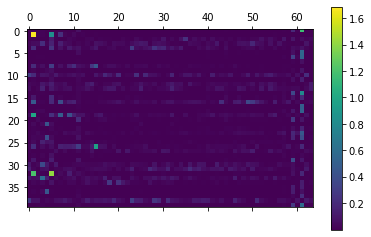

In [11]:
plt.matshow(tensor.factors[1][:40])
plt.colorbar()
plt.savefig('/home/makrai/repo/paper/Coling2020/verbtensor/img/nonneg-mx.png')

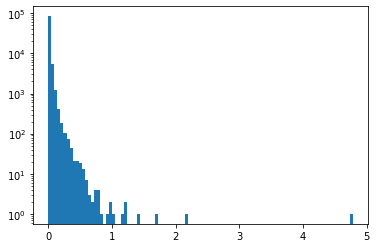

In [12]:
_ = plt.hist(tensor.factors[1].reshape(-1), log=True, bins=100)
plt.savefig('/home/makrai/repo/paper/Coling2020/verbtensor/img/nonneg-histg.png')

In [13]:
mode_names = ['nsubj', 'ROOT', 'dobj']

def show_latent(latent_i, mode_i):
    surf_indices = np.argsort(-tensor.factors[mode_i][:,latent_i])[:7]
    return latent_i, [evalor.index[mode_names[mode_i]].inv[surf_i] for surf_i in surf_indices]

In [14]:
for i, j, k in list(zip(*np.unravel_index(np.argsort(-core.reshape(-1)), core.shape)))[:8]:
    print(show_latent(i, 0))
    print(show_latent(j, 1))
    print(show_latent(k, 2))
    print()

(19, ['-rsb-', '-lsb-', 'disease', 'result', '-lsb-_NNS', '-RSB-', '%'])
(22, ['-lsb-_VBD', '-lsb-_VBP', '-lsb-_VBZ', '-lsb-_VB', '-lsb-_VBN', 'quote', 'report'])
(18, ['-rsb-', '-rsb-_NNS', '-RSB-', '-lsb-', '6', '1', '4'])

(0, ['', 'you', 'we', 'that', 'he', 'they', 'who'])
(0, ['control', 'utilize', 'modify', 'use', 'manipulate', 'construct', 'create'])
(0, ['system', 'structure', 'network', 'object', 'component', 'function', 'element'])

(0, ['', 'you', 'we', 'that', 'he', 'they', 'who'])
(4, ['educate', 'assist', 'convince', 'persuade', 'kill', 'inform', 'ask'])
(3, ['people', 'he', 'I', 'she', 'other', 'you', 'we'])

(0, ['', 'you', 'we', 'that', 'he', 'they', 'who'])
(3, ['grab', 'pull', 'put', 'throw', 'touch', 'knock', 'shove'])
(2, ['head', 'ball', 'ass', 'hand', 'cock', 'face', 'foot'])

(8, ['FIG.', 'figure', 'which', '-rrb-', 'we', 'table', 'chart'])
(15, ['illustrate', 'show', 'take', 'depict', 'make', 'use', 'receive'])
(0, ['system', 'structure', 'network', 'object', '

In [15]:
for i in range(6,16):
    print(show_latent(i, 0))

(6, ['you', '', 'that', 'we', 'I', 'they', 'company'])
(7, ['', 'system', '-rrb-', 'we', 'device', 'report', 'study'])
(8, ['FIG.', 'figure', 'which', '-rrb-', 'we', 'table', 'chart'])
(9, ['stock', 'action', 'condition', 'development', 'sale', 'Jack', 'government'])
(10, ['play', 'value', 'day', 'round', 'war', 'number', 'conversation'])
(11, ['he', 'who', 'she', 'you', 'that', 'we', 'they'])
(12, ['I', 'you', '', 'he', 'who', 'they', 'study'])
(13, ['area', 'property', 'system', 'site', 'factor', 'device', 'room'])
(14, ['it', 'Council', 'Committee', 'board', 'Board', 'House', 'Commission'])
(15, ['we', '', 'that', 'system', 'study', 'site', 'book'])


In [16]:
for i in range(10):
    print(show_latent(i, 1))

(0, ['control', 'utilize', 'modify', 'use', 'manipulate', 'construct', 'create'])
(1, ['have', 'include', 'provide', 'offer', 'give', 'contain', 'require'])
(2, ['move', 'regard', 'monitor', 'evaluate', 'control', 'optimize', 'measure'])
(3, ['grab', 'pull', 'put', 'throw', 'touch', 'knock', 'shove'])
(4, ['educate', 'assist', 'convince', 'persuade', 'kill', 'inform', 'ask'])
(5, ['include', 'have', 'affect', 'contain', 'take', 'represent', 'make'])
(6, ['increase', 'decrease', 'reduce', 'measure', 'lower', 'boost', 'calculate'])
(7, ['provide', 'give', 'receive', 'offer', 'increase', 'have', 'require'])
(8, ['build', 'expand', 'promote', 'improve', 'develop', 'enhance', 'maintain'])
(9, ['provide', 'offer', 'facilitate', 'initiate', 'prevent', 'involve', 'complete'])


In [17]:
for i in range(10):
    print(show_latent(i, 2))

(0, ['system', 'structure', 'network', 'object', 'component', 'function', 'element'])
(1, ['', 'what', 'that', 'way', '%', 'percent', 'I'])
(2, ['head', 'ball', 'ass', 'hand', 'cock', 'face', 'foot'])
(3, ['people', 'he', 'I', 'she', 'other', 'you', 'we'])
(4, ['amount', 'system', 'income', 'component', 'rate', 'chance', 'revenue'])
(5, ['frequency', 'concentration', 'density', 'probability', 'resistance', 'intensity', 'sensitivity'])
(6, ['infrastructure', 'production', 'supply', 'business', 'operation', 'efficiency', 'sale'])
(7, ['value', 'datum', 'information', 'number', 'amount', 'project', 'development'])
(8, ['experience', 'ability', 'understanding', 'capability', 'opportunity', 'strength', 'confidence'])
(9, ['transmission', 'exposure', 'production', 'spread', 'transfer', 'flow', 'position'])


## Athlete ... race

In [18]:
embed = KeyedVectors(64)

In [19]:
embed.add_vectors(list(evalor.index['ROOT'].inv.values()), tensor.factors[1])

In [20]:
def predict_verb(subj='athlete', obj='race'):
    tensor1 = tensor.core
    tensor1 = tl.tenalg.mode_dot(tensor1, evalor.lookup(subj, 0), 0)
    tensor1 = tl.tenalg.mode_dot(tensor1, evalor.lookup(obj, 2), 1)
    return embed.most_similar([tensor1])

In [21]:
predict_verb()

[('have', 0.9841201901435852),
 ('include', 0.9124106764793396),
 ('provide', 0.8667762279510498),
 ('offer', 0.8448187708854675),
 ('contain', 0.8381587862968445),
 ('require', 0.7445492148399353),
 ('give', 0.6424943804740906),
 ('need', 0.6187449097633362),
 ('feature', 0.6024946570396423),
 ('affect', 0.5970800518989563)]

In [22]:
predict_verb(subj='user', obj='command')

[('contain', 0.861118733882904),
 ('provide', 0.8168653845787048),
 ('represent', 0.8076701760292053),
 ('require', 0.7967956066131592),
 ('constitute', 0.7953993082046509),
 ('feature', 0.7923411130905151),
 ('offer', 0.7908795475959778),
 ('have', 0.7721259593963623),
 ('give', 0.7590991854667664),
 ('affect', 0.7575748562812805)]

In [23]:
tensor.factors[0].shape

(1515, 64)

# Triples by `lmbda`

In [24]:
tensor_dir = config['DEFAULT']['ProjectDirectory']+'tensor/'
evalor = VerbTensorEvaluator(cutoff=100000, decomp_algo='parafac')
modes = ['nsubj', 'ROOT', 'dobj']

In [25]:
evalor.load_embeddings()

In [26]:
evalor.decomped_tns.weights.todense()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [27]:
i_word = [{i: w for w, i in evalor.index[j].items()} for j in modes]
vocab = [np.array([i_word[j][i] for i in range(len(i_word[j]))]) for j in range(len(i_word))]
for k, j in enumerate(
        #np.argsort(-ktensor.lmbda)[:4]):#
        range(evalor.decomped_tns.rank)):
    print(f'\n{k}')# {j}')
    for i, factor in enumerate(evalor.decomped_tns.factors):
        ids = np.argsort(factor[:,j].todense())[:7]
        print(vocab[i][ids])
        #print(['{:.1g}'.format(coord) for coord in ktensor.U[i][ids,j]])


0
['' 'that' 'which' 'this' 'it' 'what' 'they']
['cause' 'trigger' 'create' 'prevent' 'produce' 'induce' 'mean']
['industry' 'life' 'ability' 'productivity' 'health' 'landscape' 'conduct']

1
['activity' 'work' 'report' 'page' 'volume' 'book' 'these']
['install' 'give' 'build' 'show' 'remove' 'pull' 'need']
['study' 'work' 'evaluation' 'assessment' 'development' 'review'
 'planning']

2
['area' 'milk' 'water' 'region' 'parameter' 'liquid' 'flavor']
['change' 'practice' 'learn' 'advance' 'embrace' 'spend' 'prevent']
['life' 'water' 'power' 'moment' 'energy' 'beauty' 'culture']

3
['car' 'kitchen' 'store' 'door' 'town' 'i' 'park']
['have' 'take' 'give' 'offer' 'produce' 'use' 'get']
['' 'effect' 'signal' 'value' 'behavior' 'what' 'characteristic']

4
['i' 'everyone' 'pace' 'browser' 'car' 'mom' 'anyone']
['have' 'facilitate' 'promote' 'enhance' 'ensure' 'improve' 'enable']
['development' 'growth' 'activity' 'production' 'movement' 'recovery'
 'use']

5
['device' 'unit' 'body' 'each' 'co

['kitchen' 'bed' 'fireplace' 'balcony' 'bathroom' 'bedroom' 'impact']

53
['i' 'change' 'paper' 'everyone' 'disease' 'condition' 'friend']
['have' 'need' 'hit' 'visit' 'love' 'cost' 'own']
['' 'I' 'which' 'you' 'that' 'we' 'he']

54
['study' 'finding' 'datum' 'result' 'researcher' 'research' 'survey']
['examine' 'comprise' 'investigate' 'change' 'enter' 'conduct' 'evaluate']
['presence' 'evidence' 'existence' 'prevalence' 'involvement' 'benefit'
 'outcome']

55
['myself' 'finger' 'license' 'permission' 'yourself' 'contract' 'patent']
['produce' 'form' 'pour' 'heat' 'clean' 'contain' 'fill']
['' 'what' 'water' 'that' 'fluid' 'air' 'blood']

56
['book' 'chapter' 'paper' 'article' 'dress' 'price' 'clothes']
['change' 'curb' 'fit' 'choose' 'match' 'cut' 'fill']
['crime' 'violence' 'corruption' 'fraud' 'act' 'himself' 'top']

57
['battle' 'payment' 'novel' 'Pakistan' 'US' 'budget' 'war']
['seek' 'send' 'hire' 'read' 'file' 'become' 'accelerate']
['someone' 'man' 'God' 'loss' 'letter' 'woman

|rank|$\lambda$|e.g.|
|----|---------|----|
|16|1|topic/example (2) provide/offer (2) assistance/guidance|
|32|1|Android (3)  win degree (1)|
|64|1|I describe (1) game/story (2)|